In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
from lmfit import  Model, Parameters
%matplotlib inline

In [2]:
!ls ../data/

enregistrement_BMC_2017-09-26_095637.EDF
enregistrement_BMC_2017-09-26_095637.asc
enregistrement_BMC_2017-09-26_095637.pkl
enregistrement_DC_2017-09-27_161040.asc
enregistrement_DC_2017-09-27_161040.edf
enregistrement_DC_2017-09-27_161040.pkl
enregistrement_IP_2017-09-28_115250.asc
enregistrement_IP_2017-09-28_115250.edf
enregistrement_IP_2017-09-28_115250.pkl
enregistrement_LB_2017-09-20_151043 (1).asc
enregistrement_LB_2017-09-20_151043.asc
enregistrement_LB_2017-09-20_151043.edf
enregistrement_LB_2017-09-20_151043.pkl
pari_BMC_2017-09-25_142503.pkl
pari_CS_2017-09-28_154353.pkl
pari_DC_2017-09-26_162348.pkl
pari_FM_2017-09-26_143606.pkl
pari_IP_2017-09-26_122431.pkl
pari_LB_2017-09-19_152205.pkl


In [3]:
timeStr = '2017-09-20_151043'
observer = 'LB'
mode = 'enregistrement'

In [4]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [6]:
def anticipation (x, tau=0.013, xT=0.1, t_T=1, start_anti=500., v_anti=0.1, latence=1000., bino=0) :
    '''
    tau -- constante oeuil (0.013)
    xT -- position en deg de la cible (1)
    t_T -- tps du mvt - s (0.1)
    latence -- tps où commence le mvt
    bino -- binomial
    
    start_anti = debut de l'anticipation
    v_anti =  vitesse de l'anticipation
    ''' 
    if bino == 0:
        xT =xT*-1
    
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
    time = np.arange(len(x))/1000 # en seconde !!!
    start = latence/1000
    start_anti=start_anti/1000
    
    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    rhoT = int(np.round(T*rho)) # tps accélération
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N
    x_max = Umax*tau*(1-np.exp(-1/tau*time[rhoT]))

    vitesse = []

    if start_anti >= start :
        for t in range(len(time)):
            if (bino*2-1)*Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) < 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))

    
    else :
        for t in range(len(time)):
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if (bino*2-1)*Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) > 0 :
                    vitesse.append(((time[t]-start_anti)*v_anti))
                    x = (time[t]-start_anti)*v_anti
                else :
                    vitesse.append((Umax*tau*(1-np.exp(-1/tau*(time[t]-start)))+x))

    return vitesse

[0.0, 6.8459251459854951, 8.2151101751813496, 4.1075550875906748, 1.3691850291974104, 1.3691850291974104, 1.3691850291974104, 8.2151101751829056, 12.322665262773581, 6.8459251459854951, 0.0, 0.0, 5.4767401167880854, 6.8459251459854951, 0.0, -5.4767401167880854, -1.3691850291958538, 2.7383700583932642, 2.7383700583932642, 0.0, 1.3691850291974104, 8.2151101751829056, 9.5842952043803162, 6.8459251459854951, 4.1075550875906748, 2.7383700583948207, 1.3691850291974104, -2.7383700583948207, -8.2151101751829056, -9.5842952043787601, -2.7383700583948207, 2.7383700583932642, 4.1075550875922309, 2.7383700583948207, -1.3691850291974104, -2.7383700583948207, -2.7383700583948207, -1.3691850291974104, 0.0, 0.0, 2.7383700583948207, 4.1075550875922309, 0.0, -4.1075550875922309, -4.1075550875906748, -2.7383700583932642, 0.0, 2.7383700583932642, 2.7383700583932642, -1.3691850291958538, -5.4767401167880854, -6.8459251459854951, -4.1075550875906748, 1.3691850291958538, -1.3691850291974104, -6.8459251459854

ValueError: setting an array element with a sequence.

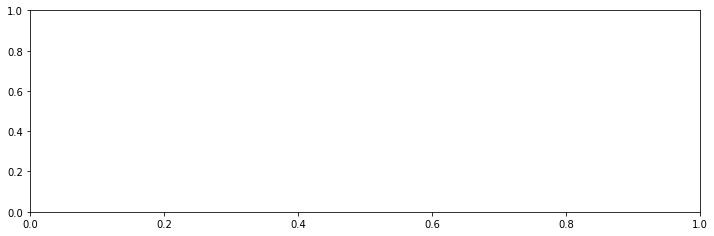

In [8]:
fig_width= 12
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
block = 1
trial = 30


trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']

StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']
trackertime_0 = data[trial_data]['trackertime'][0]

gradient_x = np.gradient(data_x) # gradient en px/ms
gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

# SUPPRESSION DES SACCADES
new_gradient_deg=[]
new_time=[]
t=0
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
            saccade = 'yes'
    if not saccade :
        new_gradient_deg.append(gradient_deg[x_data])
        new_time.append(t)
        t = t+1
    saccade = None

StimulusOn_0 = StimulusOn
StimulusOf_0 = StimulusOf
TargetOn_0 = TargetOn
TargetOff_0 = TargetOff

for s in range(len(saccades)) :
    if StimulusOn_0 > (saccades[s][1]) :
        StimulusOn = StimulusOn - (saccades[s][2]+5)
    if StimulusOf_0 > (saccades[s][1]) :
        StimulusOf = StimulusOf - (saccades[s][2]+5)
    if TargetOn_0 > (saccades[s][1]) :
        TargetOn = TargetOn - (saccades[s][2]+5)
    if TargetOff_0 > (saccades[s][1]) :
        TargetOff = TargetOff - (saccades[s][2]+5)

start = TargetOn

StimulusOn_s = StimulusOn - start
StimulusOf_s = StimulusOf - start
TargetOn_s = TargetOn - start
TargetOff_s = TargetOff - start
trackertime_s = trackertime - start
        
# FIT
model = Model(anticipation)
bino=p[trial, block, 0]
params = Parameters()
params.add('tau', value=0.013, min=0.013, max=0.019)#, vary=False)
params.add('xT', value=1.2, min=0.04, max=1.8)# , vary=False)
params.add('t_T', value= 0.12, min=0.05, max=0.2)#, vary=False)
params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0, max=len(new_gradient_deg))

params.add('start_anti', value=StimulusOf-trackertime_0+100, min=StimulusOf-trackertime_0, max=TargetOn-trackertime_0)
params.add('v_anti', value=0., min=-0.88, max=0.89)

params.add('bino', value=bino, min=0, max=1, vary=False)

print(new_gradient_deg, params, new_time)
result_deg = model.fit(new_gradient_deg, params, x=new_time)

debut  = TargetOn - trackertime_0 # TargetOn - temps_0


axs.axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])

axs.plot(np.asarray(new_time)-debut, new_gradient_deg, color='r', alpha=0.6)
axs.plot(np.asarray(new_time)-debut, result_deg.init_fit, 'k--', linewidth=2)
axs.plot(np.asarray(new_time)-debut, result_deg.best_fit, color='k', linewidth=2)
axs.plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(bino*2-1)*15, color='k', linewidth=0.2)
axs.plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(bino*2-1)*10, color='k', linewidth=0.2)

axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)

start_anti = result_deg.values['start_anti']
v_anti = result_deg.values['v_anti']
latence = result_deg.values['latence']
tau = result_deg.values['tau']
xT = result_deg.values['xT']
t_T = result_deg.values['t_T']

axs.bar(latence-debut, 80, bottom=-40, color='g', width=6, linewidth=0)

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 30, "FIXATION", color='k', fontsize=12, horizontalalignment='center')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 30, "GAP", color='r', fontsize=12, horizontalalignment='center')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 30, "POURSUITE", color='k', fontsize=12, horizontalalignment='center')
axs.text(latence-debut+25, -30, "Latence = %s"%(latence-debut), color='g', fontsize=12)#,  weight='bold')
#axs.text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=10)
axs.text(StimulusOn_s+15, -36, "start_anti: %4.2f \nv_anti: %0.2f \n\nlatence: %4.2f \ntau: %0.2f \nxT: %0.2f \nt_T: %0.2f"%(start_anti-debut, v_anti, latence-debut, tau, xT, t_T), color='k', fontsize=10)

axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)

print(result_deg.fit_report())
print(start_anti, v_anti, latence, tau, xT, t_T)


0 0


ValueError: setting an array element with a sequence.

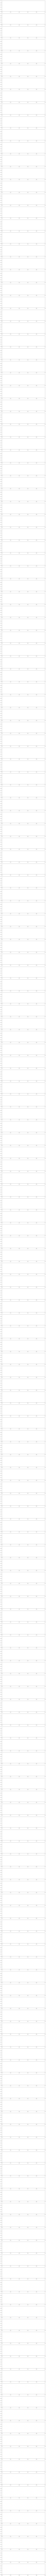

In [9]:
for block in range(N_blocks) :
    fig_width= 12
    fig, axs = plt.subplots(N_trials, 1, figsize=(fig_width, (fig_width*(N_trials/2))/1.6180))
    
    for trial in range(N_trials) :
        
        print(block, trial)
        
        trial_data = trial + N_trials*block
        data_x = data[trial_data]['x']
        data_y = data[trial_data]['y']
        trackertime = data[trial_data]['trackertime']

        StimulusOn = data[trial_data]['events']['msg'][10][0]
        StimulusOf = data[trial_data]['events']['msg'][14][0]
        TargetOn = data[trial_data]['events']['msg'][15][0]
        TargetOff = data[trial_data]['events']['msg'][16][0]
        saccades = data[trial_data]['events']['Esac']

        trackertime_0 = data[trial_data]['trackertime'][0]

        gradient_x = np.gradient(data_x)
        gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec
        
        
        # SUPPRESSION DES SACCADES
        #new_gradient_x=[]
        new_gradient_deg=[]
        new_time=[]
        t=0
        for x_data in range(len(data_x)):
            saccade = None
            for s in range(len(saccades)) :
                if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
                    saccade = 'yes'
            if not saccade :
                new_gradient_deg.append(gradient_deg[x_data])
                new_time.append(t)
                t = t+1
            saccade = None
        
        StimulusOn_0 = StimulusOn
        StimulusOf_0 = StimulusOf
        TargetOn_0 = TargetOn
        TargetOff_0 = TargetOff

        for s in range(len(saccades)) :
            if StimulusOn_0 > (saccades[s][1]) :
                StimulusOn = StimulusOn - (saccades[s][2]+5)
            if StimulusOf_0 > (saccades[s][1]) :
                StimulusOf = StimulusOf - (saccades[s][2]+5)
            if TargetOn_0 > (saccades[s][1]) :
                TargetOn = TargetOn - (saccades[s][2]+5)
            if TargetOff_0 > (saccades[s][1]) :
                TargetOff = TargetOff - (saccades[s][2]+5)

        start = TargetOn

        StimulusOn_s = StimulusOn - start
        StimulusOf_s = StimulusOf - start
        TargetOn_s = TargetOn - start
        TargetOff_s = TargetOff - start
        trackertime_s = trackertime - start
    

        # FIT
        model = Model(anticipation)

        bino=p[trial, block, 0]
        params = Parameters()
        #params.add('tau', value=0.013, min=0.013, max=0.02)#, vary=False)
        #params.add('xT', value=0.05, min=0.04, max=1)# , vary=False)
        #params.add('t_T', value= 0.1, min=0.05, max=0.2)#, vary=False)
        #params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0, max=len(new_gradient_x))

        #params.add('start_anti', value=StimulusOf-trackertime_0, min=StimulusOf-trackertime_0, max=len(new_gradient_x))
        #params.add('v_anti', value=0., min=-0.89, max=0.89)

        #params.add('bino', value=bino, min=0, max=1, vary=False)

        ####################"
        params.add('tau', value=0.013, min=0.013, max=0.02)#, vary=False)
        params.add('xT', value=1.3, min=0.04, max=1.9)# , vary=False)
        params.add('t_T', value= 0.12, min=0.05, max=0.2)#, vary=False)
        params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0, max=len(new_gradient_deg))

        params.add('start_anti', value=StimulusOf-trackertime_0, min=StimulusOf-trackertime_0, max=len(new_gradient_deg))
        params.add('v_anti', value=0., min=-0.89, max=0.89)

        params.add('bino', value=bino, min=0, max=1, vary=False)
        ####################"
        
        result_deg = model.fit(new_gradient_deg, params, x=new_time)
        
        debut  = TargetOn - trackertime_0 # TargetOn - temps_0
        
        axs[trial].cla() # pour remettre ax figure a zero
        axs[trial].axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])
        
        axs[trial].plot(np.asarray(new_time)-debut, new_gradient_deg, color='r', alpha=0.6)
        axs[trial].plot(np.asarray(new_time)-debut, result_deg.init_fit, 'k--', linewidth=2)
        axs[trial].plot(np.asarray(new_time)-debut, result_deg.best_fit, color='k', linewidth=2)
        axs[trial].plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(15), color='k', linewidth=0.2)
        axs[trial].plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(10), color='k', linewidth=0.2)
        axs[trial].plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(-15), color='k', linewidth=0.2)
        axs[trial].plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(-10), color='k', linewidth=0.2)
        
        axs[trial].axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
        axs[trial].axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
        axs[trial].axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)

        start_anti = result_deg.values['start_anti']
        v_anti = result_deg.values['v_anti']
        latence = result_deg.values['latence']
        tau = result_deg.values['tau']
        xT = result_deg.values['xT']
        t_T = result_deg.values['t_T']
        
        
        
        axs[trial].bar(latence-debut, 80, bottom=-40, color='g', width=6, linewidth=0)
        
        axs[trial].text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 35, "FIXATION", color='k', fontsize=12, horizontalalignment='center')
        axs[trial].text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 35, "GAP", color='r', fontsize=12, horizontalalignment='center')
        axs[trial].text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 35, "POURSUITE", color='k', fontsize=12, horizontalalignment='center')
        axs[trial].text(latence-debut+25, -35, "Latence = %s"%(latence-debut), color='g', fontsize=12)#,  weight='bold')
        #axs[trial].text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=15)
        axs[trial].text(StimulusOn_s+15, -36, "start_anti: %4.2f \nv_anti: %0.2f \n\nlatence: %4.2f \ntau: %0.2f \nxT: %0.2f \nt_T: %0.2f"%(start_anti-debut, v_anti, latence-debut, tau, xT, t_T), color='k', fontsize=10)

        
        axs[trial].set_xlabel('Time (ms)', fontsize=9)
        axs[trial].set_ylabel(trial+1, fontsize=9)

    plt.tight_layout() # pour supprimer les marge trop grande
    plt.subplots_adjust(hspace=0) # pour enlever espace entre les figures

    plt.savefig('figures/Fit_anticipation_%s_%s_block-%s_deg.pdf'%(observer, timeStr, block+1))
plt.close()